# Outline

## 1. Example Program: Viewing ranking as a simple regression problem

## 2. Example Program: Enhanced implementation based on PyTorch

### 1.1 Import libariries & mount data folder


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

### 1.2 The program for loading the example data 

In [ ]:
# The function for loading data
def load_LETOR4(file, num_features=46):
	'''
	:param file: the input file
	:param num_features: the number of features
	:return: the list of tuples, each tuple consists of qid, doc_reprs, doc_labels
	'''
  
	feature_cols = [str(f_index) for f_index in range(1, num_features + 1)]

	df = pd.read_csv(file, sep=" ", header=None)
	df.drop(columns=df.columns[[-2, -3, -5, -6, -8, -9]], axis=1, inplace=True)  # remove redundant keys
	assert num_features == len(df.columns) - 5

	for c in range(1, num_features +2):           							 # remove keys per column from key:value
		df.iloc[:, c] = df.iloc[:, c].apply(lambda x: x.split(":")[1])

	df.columns = ['rele_truth', 'qid'] + feature_cols + ['#docid', 'inc', 'prob']

	for c in ['rele_truth'] + feature_cols:
		df[c] = df[c].astype(np.float32)

	df['rele_binary'] = (df['rele_truth'] > 0).astype(np.float32)  # additional binarized column for later filtering

	list_Qs = []
	qids = df.qid.unique()
	np.random.shuffle(qids)
	for qid in qids:
		sorted_qdf = df[df.qid == qid].sort_values('rele_truth', ascending=False)

		doc_reprs = sorted_qdf[feature_cols].values
		doc_labels = sorted_qdf['rele_truth'].values

		list_Qs.append((qid, doc_reprs, doc_labels))

	#if buffer: pickle_save(list_Qs, file=perquery_file)

	return list_Qs

#### The program for computing nDCG score

In [ ]:
def discounted_cumu_gain_at_k(sorted_labels, cutoff):
	'''
	:param sorted_labels: ranked labels (either standard or predicted by a system) in the form of np array
	:param max_cutoff: the maximum rank position to be considered
	:param multi_lavel_rele: either the case of multi-level relevance or the case of listwise int-value, e.g., MQ2007-list
	:return: cumulative gains for each rank position
	'''
	nums = np.power(2.0, sorted_labels[0:cutoff]) - 1.0

	denoms = np.log2(np.arange(cutoff) + 2.0)  # discounting factor
	dited_cumu_gain = np.sum(nums / denoms)

	return dited_cumu_gain

def ndcg_at_k(sys_sorted_labels, ideal_sorted_labels, k):
	sys_discounted_cumu_gain_at_k = discounted_cumu_gain_at_k(sys_sorted_labels, cutoff=k)
	ideal_discounted_cumu_gain_at_k = discounted_cumu_gain_at_k(ideal_sorted_labels, cutoff=k)
	ndcg_at_k = sys_discounted_cumu_gain_at_k / ideal_discounted_cumu_gain_at_k
	return ndcg_at_k

### 1.3 The training prgoram

Note: this program is based on the previous regression program.

In [ ]:
def reg_gradient_descent(list_Qs, theta, learning_rate=0.001, repeat_times=5):
  cost_history = np.zeros(repeat_times)

  for k in range(repeat_times): # number of iterations, i.e., epochs
    for (qid, train_X, train_Y) in list_Qs: # the training dataset
      m = len(train_Y)    # the number of documents that are associated with the same query
      for i in range(m):  # perform regression for each document
        x = train_X[i, :] # one document's feature vector
        y = train_Y[i]    # the corresponding truth label

        prediction = np.dot(x, theta)       # prediction

        theta = theta - learning_rate*(x*(prediction - y)) # gradient descent

    cost=0
    for (qid, train_X, train_Y) in list_Qs:
      predictions_per_query = train_X.dot(theta)
      m = len(train_Y)
      cost_per_query = 0.5 * m * np.sum(np.square(predictions_per_query-train_Y))
      cost += cost_per_query

    cost_history[k]  = cost # record the cost/loss per epoch
        
  return theta, cost_history

### 1.4 The evaluation program for testing the ranking model based on nDCG

In [ ]:
def evaluate(test_list_Qs, optimized_theta, k=5):
  nDCG=0.0
  count = 0.0 # count the number of test queries
  for (qid, test_X, test_Y) in test_list_Qs:
    sum_per_query = np.sum(test_Y)
    m = len(test_Y)
    if m < k or sum_per_query <= 0: # filter out queries that: (1) include less documents than k; (2) include no relevant documents
      continue
    else:
      count += 1
    
    predictions_per_query = test_X.dot(optimized_theta) # the predictions with respect to one query

    ideal_sorted_labels = np.sort(test_Y)               # the default is ascending order
    ideal_sorted_labels = np.flip(ideal_sorted_labels)  # convert to the descending order
    #print('ideal_sorted_labels', ideal_sorted_labels)

    sorted_pred_indice = np.argsort(-predictions_per_query) # get the indice that sort the predictions in a descending order
    sys_sorted_labels = test_Y[sorted_pred_indice]          # get the corresponding ranking of standard labels 
    #print('sys_sorted_labels', sys_sorted_labels)

    nDCG_per_query = ndcg_at_k(sys_sorted_labels=sys_sorted_labels, ideal_sorted_labels=ideal_sorted_labels, k=k)
    nDCG += nDCG_per_query

  nDCG = nDCG/count # using the average nDCG
  return nDCG

### 1.5 Demonstration: how to learn a ranking model based on linear regression.

Random initialization of parameters: [ 9.11178067e-01 -5.76038733e-01 -7.56432352e-01 -3.10080988e+00
  1.05777579e+00  7.39447848e-01  3.52891209e-01  2.08065579e+00
  2.99709110e-01  3.15223189e-01 -1.06872935e+00  1.51137306e-01
 -1.04792840e-01 -3.73001079e-01 -3.44608925e-01  6.42061337e-01
 -8.92084101e-01 -2.16751373e+00 -4.24147477e-01  6.04039538e-01
  2.43232480e-01 -6.80492291e-01 -8.90267105e-02 -1.49162656e+00
  1.39192665e+00  3.19284179e-01  6.85983976e-01 -3.90312304e-01
 -9.37911519e-04  5.29418193e-01 -7.75215575e-01  5.32072225e-01
  1.34311213e+00  1.45271303e-01  7.44427055e-01  6.66068943e-01
  8.03641929e-01  8.97238934e-01  1.27329434e-01  3.04482693e-02
  1.54428396e+00 -1.16073570e+00 -4.93709809e-01 -4.23906257e-01
  1.28294473e+00  7.69712851e-01]

 Optimized parameters:[ 0.09876928 -0.27279837 -0.07462729 -1.46644274  0.1178233   0.73944785
  0.35289121  2.08065579  0.29970911  0.31522319 -0.41944495  0.22998108
  0.29773113  0.4142304   0.15173159  0.05573

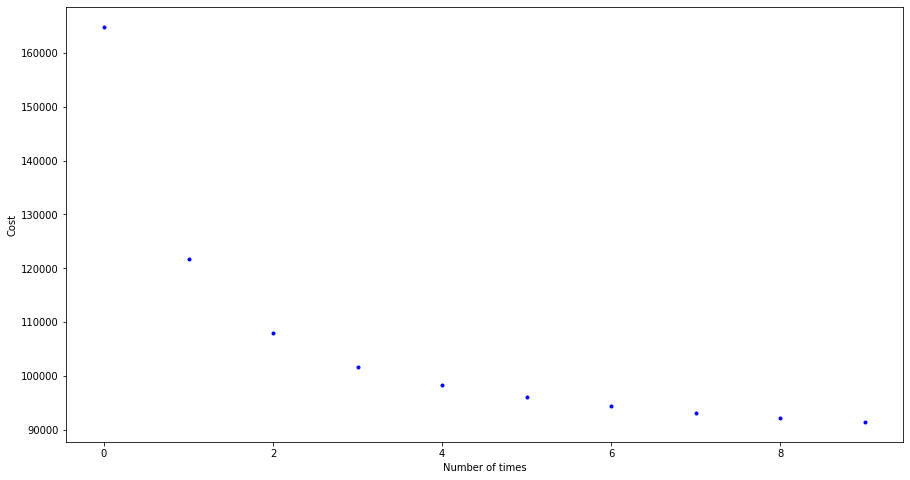

In [ ]:
repeat_times = 10
X_Dimension = 46

debug = True # print some information if needed

initial_theta = np.random.randn(X_Dimension) # initialization of the prameters
if debug:
  print('Random initialization of parameters: {}'.format(initial_theta))

# load the training data
file = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/vali_as_train.txt'
train_list_Qs = load_LETOR4(file=file)

#training the model based on gradient descent algorithm
optimized_theta, cost_history = reg_gradient_descent(train_list_Qs, initial_theta, learning_rate=0.001, repeat_times=repeat_times)

if debug:
  print('\n Optimized parameters:{}'.format(optimized_theta))

# evaluate the ranking model by computing its nDCG score
# load the test data
file = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/test.txt'
test_list_Qs = load_LETOR4(file=file)

nDCG = evaluate(test_list_Qs=test_list_Qs, optimized_theta=optimized_theta)
print('\n The nDCG score of the optimized ranking model is:', nDCG)


# show the cost variation w.r.t. the training process
print()
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylabel('Cost')
ax.set_xlabel('Number of times')
ax.plot(range(repeat_times), cost_history[:repeat_times], 'b.')



### 2.1 Import libraries

In [ ]:
!pip install ptranking

     |████████████████████████████████| 122kB 11.8MB/s 


### 2.2 Import necessary classes provided by PTRanking

In [ ]:
import torch
from ptranking.data.data_utils import LTRDataset, SPLIT_TYPE

### 2.3 Define a neural ranking class

For more details, please refer to: https://wildltr.github.io/ptranking/how_to_start/Develop_A_New_Model/


In [ ]:
import torch.nn as nn
from ptranking.base.ranker import NeuralRanker

mse = nn.MSELoss() # mean square error function provided by PyTorch

class MLIRMSE(NeuralRanker):
	def __init__(self, sf_para_dict=None, gpu=False, device=None):
		super(MLIRMSE, self).__init__(id='RankMSE', sf_para_dict=sf_para_dict, gpu=gpu, device=device)
		self.TL_AF = self.get_tl_af()

	def inner_train(self, batch_pred, batch_label, **kwargs):
		'''
		:param batch_preds: [batch, ranking_size] each row represents the relevance predictions for documents within a ltr_adhoc
		:param batch_stds: [batch, ranking_size] each row represents the standard relevance grades for documents within a ltr_adhoc
		:return:
		'''

		batch_loss = mse(batch_pred, batch_label)
		# gradient back-propagation
		self.optimizer.zero_grad()	
		batch_loss.backward()
		self.optimizer.step()

		return batch_loss



### 2.4 Define a neural scoring fuction

It is a component of the NeuralRanker


In [ ]:
from ptranking.ltr_adhoc.eval.parameter import ScoringFunctionParameter


class MLIRSFP(ScoringFunctionParameter):
    """
    The parameter class w.r.t. a neural scoring fuction
    """
    def __init__(self):
        super(MLIRSFP, self).__init__()

    def default_para_dict(self):
        """
        A default setting of the hyper-parameters of the stump neural scoring function.
        """
        # feed-forward neural networks
        ffnns_para_dict = dict(num_layers=5, HD_AF='R', HN_AF='R', TL_AF='S', apply_tl_af=True, BN=True, RD=False, FBN=False)

        sf_para_dict = dict()
        sf_para_dict['id'] = self.model_id
        sf_para_dict[self.model_id] = ffnns_para_dict

        self.sf_para_dict = sf_para_dict
        return sf_para_dict

  

### 2.5 Perform learning-to-rank based on PTRanking

In [ ]:
from ptranking.data.data_utils import get_data_meta
from ptranking.ltr_adhoc.eval.eval_utils import ndcg_at_ks, ndcg_at_k
from ptranking.metric.adhoc_metric import torch_nDCG_at_k, torch_nDCG_at_ks

gpu, device = False, None

##- Data loading -##
file_train = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/vali_as_train.txt'

file_test = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/test.txt'

train_data = LTRDataset(data_id='MQ2007_Super', file=file_train, split_type=SPLIT_TYPE.Train, batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)

test_data = LTRDataset(data_id='MQ2007_Super', file=file_test, split_type=SPLIT_TYPE.Test, shuffle=False, data_dict=None, batch_size=1, buffer=False)

data_meta = get_data_meta(data_id='MQ2007_Super')

sf_para_dict = MLIRSFP().default_para_dict()

sf_para_dict['ffnns'].update(dict(num_features=data_meta['num_features']))


# Initialize the ranking class as a ranker
mlir_ranker = MLIRMSE(sf_para_dict=sf_para_dict)

# Training
epoch_loss = torch.cuda.FloatTensor([0.0]) if gpu else torch.FloatTensor([0.0])

# Training for each query
for qid, batch_rankings, batch_stds in train_data: # _, [batch, ranking_size, num_features], [batch, ranking_size]
    if gpu: batch_rankings, batch_stds = batch_rankings.to(device), batch_stds.to(device)

    batch_loss, stop_training = mlir_ranker.train(batch_rankings, batch_stds, qid=qid)

    #print(batch_loss)
    epoch_loss += batch_loss.item()


# Testing
ks=[1, 5, 10]
sum_ndcg_at_ks = torch.zeros(len(ks))
cnt = torch.zeros(1)
already_sorted = True if test_data.presort else False
for qid, batch_ranking, batch_labels in test_data: # _, [batch, ranking_size, num_features], [batch, ranking_size]

    if torch.sum(batch_labels) <=0: # filter dumb queries
      continue

    if gpu: batch_ranking = batch_ranking.to(device)
    batch_rele_preds = mlir_ranker.predict(batch_ranking)
    if gpu: batch_rele_preds = batch_rele_preds.cpu()

    _, batch_sorted_inds = torch.sort(batch_rele_preds, dim=1, descending=True)

    batch_sys_sorted_labels = torch.gather(batch_labels, dim=1, index=batch_sorted_inds)
    if already_sorted:
        batch_ideal_sorted_labels = batch_labels
    else:
        batch_ideal_sorted_labels, _ = torch.sort(batch_labels, dim=1, descending=True)

    batch_ndcg_at_ks = torch_nDCG_at_ks(batch_sys_sorted_labels=batch_sys_sorted_labels, batch_ideal_sorted_labels=batch_ideal_sorted_labels, ks=ks)

    # default batch_size=1 due to testing data
    sum_ndcg_at_ks = torch.add(sum_ndcg_at_ks, torch.squeeze(batch_ndcg_at_ks, dim=0))
    cnt += 1

avg_ndcg_at_ks = sum_ndcg_at_ks/cnt
print(avg_ndcg_at_ks)

tensor([0.4747, 0.4781, 0.5191])
